# Interpolation

When you have data at specific points, but want to know it at other points you need to interpolate. Here we discuss two-dimensional interpolation, though the same principles apply for 1D and ND interpolation.

We will talk about the easiest and most common way to interpolate in 2D (`griddata`), but notes about other methods are preserved later in the notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import spatial
import scipy.interpolate
from scipy.ndimage.interpolation import map_coordinates

import cartopy
import cmocean.cm as cmo

## [`griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)

This way is not fast because it cannot take advantage of structured (predictably-spaced) data. However, it generally works and is pretty straight-forward.

    Z = scipy.interpolate.griddata(pts, z, xy, method='cubic', fill_value=0)

where `pts` is Nx2 and contains the coordinates for the input data, `z` are the values at `pts`, `xy` are the coordinates where you want to interpolate to, `Z` are the values of the function `z` at `xy` locations. `method` can be 'linear', 'nearest', 'cubic', and `fill_value` fills in outside of the points.

In [6]:
x = np.random.rand(1000)
y = np.random.rand(1000)
z = np.sin((x**2 + y**2)*5.0)

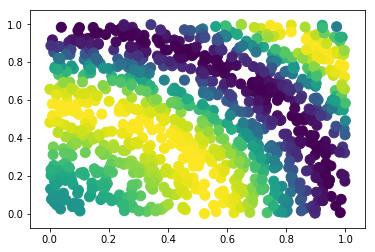

In [7]:
plt.scatter(x, y, c=z, s=100, cmap='viridis')

In [8]:
pts = np.vstack((x,y)).T  # combine x and y to get Nx2 array

# Now interpolate to new values 
# set up coordinate arrays for x and y that cover the full range of the 
# x and y coordinates
xi = np.linspace(x.min(), x.max(), 501)
yi = np.linspace(y.min(), y.max(), 501)
# X and Y are these arrays
X, Y = np.meshgrid(xi, yi)  # uniform grid

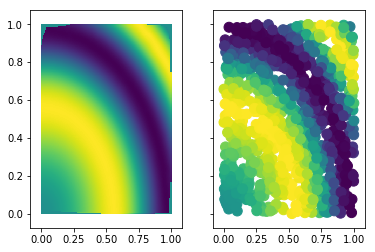

In [10]:
# griddata can't assume you are inputting structured arrays, so we put them in as coordinates
xy = np.vstack((X.flat, Y.flat)).T
Zgrid = scipy.interpolate.griddata(pts, z, xy, method='cubic', fill_value=0)

# reconstitute the output to structured array so we can plot it with pcolormesh
Zgrid.shape = X.shape

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].pcolormesh(X, Y, Zgrid, cmap='viridis')
axes[1].scatter(x, y, c=z, s=100, cmap='viridis')

# Interpolation on a map

There is a special case to consider when you need to interpolate on a map with x/y coordinates that are in longitude/latitude. When latitude and longitude are changing uniformly, it is fine (such as when you are moving along a single latitude or single longitude), but when you are changing between multiple, the values of each decimal degree changes in space. This needs to be accounted for by first projecting your coordinates.

See below for an illustration of how distance between longitude meridians can change substantially, especially near the poles:

---
### *Exercise* 

>  Texas A&M at [GERG](http://gerg.tamu.edu/) maintains a set of buoys to measure currents, especially for oil spill prediction. We can access the [data](http://tabs.gerg.tamu.edu/) online. I have pulled out a few data points of speed of the currents at each location for this example.

> Plot the winds on a map.

> Project into a projection so that you can work with meters instead of degrees, with `proj.transform_points` for projection instance `proj`.

> Interpolate the buoy data onto a grid, and plot it on a map.

---

In [66]:
# buoys in order B, F, K, R, V
# 28° 58.9386'N   94° 53.9436'W, 28° 50.5500'N   94° 14.4960'W, 26° 13.0080'N   96° 29.9880'W
# 29° 38.1000'N   93° 38.5020'W, 27° 53.7960'N   93° 35.8380'W
x = np.array([-(94+53.9436/60), -(94+14.4960/60), -(96+29.9880/60), -(93+38.5020/60), -(93+35.8380/60)])
y = np.array([28+58.9386/60, 28+50.5500/60, 26+13.0080/60, 29+38.1/60, 27+53.796/60])

# Wind speeds 10/25/16, in cm/s, in order above
s = np.array([6.21, 11.05, 3, 6.19, 8.61])


# Structured data 

For when data is uniformly gridded. Say you have this gridded data, but you want to know it at points where you have other data so that you can do a calculation at those particular locations. Then the gridded data is the structured data input to the interpolation functions, and the points you want to know it at are the interpolation points.


## `RectBivariateSpline`

[`scipy.interpolate.RectBivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline)

* Input the x and y coordinates, which need to be in monotonically increasing order. They are just 1d arrays (not 2d) because if they were arrays, the coordinates would just be repeated across the array, by definition of being uniformly gridded.
* You can choose the degree of the spline with input keyword arguments `kx`, `ky`

First create an object from which you can interpolate by inputting your data information, then use your interpolating function, f, to interpolate to other x, y locations.

    pts = np.array([[x1, y1], [x2, y2]])  # points to interpolate to

    f = scipy.interpolate.RectBivariateSpline(x, y, Z)
    zinterp = f.ev(pts[:,0], pts[:,1])


## `map_coordinates`

[`scipy.ndimage.interpolation.map_coordinates`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.interpolation.map_coordinates.html)

* Faster, but confusing to use.
* You do not put in the coordinates of the original data because they are assumed to be located at indices from 0 to the size in each dimension.
* You input the places you want to interpolate to with an array of shape [2xN] for N data points


    zinterp = map_coordinates(Z, pts.T)

We'll do a boring example so that we can be clear on the answers:

(-0.5, 9.5, -0.5, 19.5)

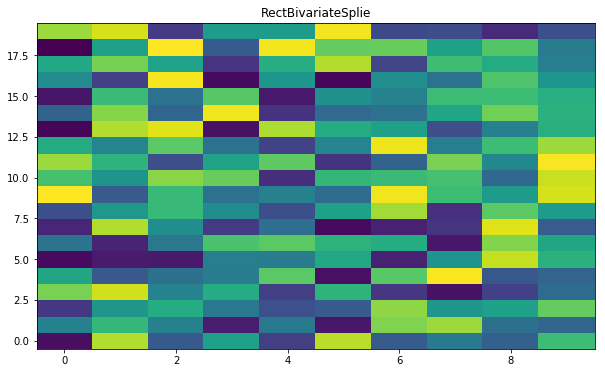

In [12]:
# get an array of values
x = np.arange(10)  # x coordinates of original function
y = np.arange(20)  # y coordinates of original function

Z = np.random.rand(x.size, y.size)  # original function


# get coordinate arrays for plotting
# these are shifted by 0.5 so that pcolormesh plots them aligned correctly
X, Y = np.meshgrid(np.linspace(x.min()-0.5, x.max()+0.5, 11), np.linspace(y.min()-0.5, y.max()+0.5, 21))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.pcolormesh(X, Y, Z.T, cmap='viridis')
ax.set_title('RectBivariateSplie')
ax.axis('tight')

In [13]:
# where to interpolate to
pts = np.array([[3, 15],[5.5, 11.5], [2.25, 17.8]])

# RectBivariateSpline
frbs = scipy.interpolate.RectBivariateSpline(x, y, Z)  # interpolator
zrbs = frbs.ev(pts[:,0], pts[:,1])

## map_coordinates
out = map_coordinates(Z, pts.T)


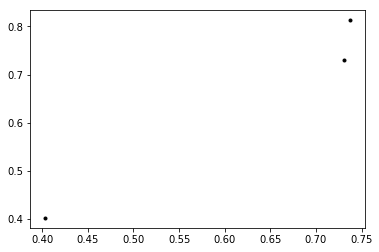

In [14]:
plt.plot(zrbs, out, '.k')

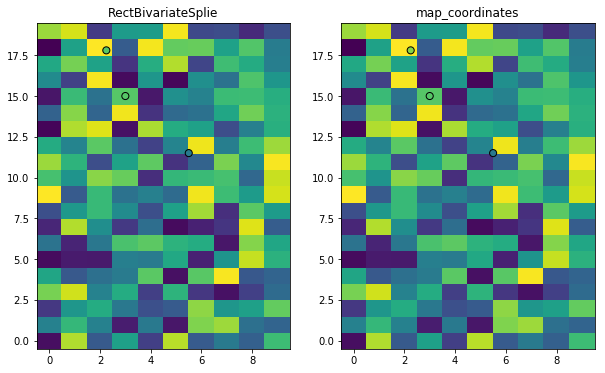

In [16]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.pcolormesh(X, Y, Z.T, cmap='viridis', vmin=Z.min(), vmax=Z.max())
ax.scatter(pts[:,0], pts[:,1], c=zrbs, s=50, cmap='viridis', vmin=Z.min(), vmax=Z.max(), edgecolor='k')
ax.set_title('RectBivariateSplie')
ax.axis('tight')

ax = fig.add_subplot(1,2,2)
ax.pcolormesh(X, Y, Z.T, cmap='viridis', vmin=Z.min(), vmax=Z.max())
ax.scatter(pts[:,0], pts[:,1], c=out, s=50, cmap='viridis', vmin=Z.min(), vmax=Z.max(), edgecolor='k')
ax.axis('tight')
ax.set_title('map_coordinates')

# Unstructured data 

For when data is *not* uniformly gridded. Say you have gathered data in the field at some points, but you want to have a nice spatial view of how it looks across a whole area. Then you may want to interpolate it from the triplet data (the field data at some points) to regularly-gridded locations (for viewing).

Here is example data we'll use to interpolate onto a regular, uniform grid:

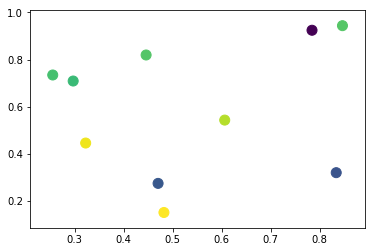

In [17]:
# this time we have triplets, not structured data
x = np.random.rand(10)
y = np.random.rand(10)
z = np.random.rand(10)

# rename for later convenience
pts = np.vstack((x,y)).T

plt.scatter(x, y, c=z, s=100, cmap='viridis')

## Delaunay triangulation and interpolation

Given a number of points, [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) divides the plane into a series of triangles, using the given points as the vertices of the triangles, such that each triangle does not contain any other points (technically, no points are within the circumcircle).

An advantage of using this approach for interpolation is that you can create the triangulation once – which is the potentially slow step – and then use it for subsequent interpolations, assuming your underlying data is not changing.

Here is a sample of what that looks like, for the points shown in black dots:

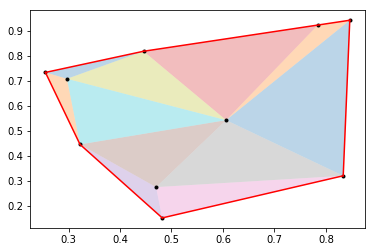

In [19]:
tri = spatial.Delaunay(pts)

# The individual triangles, colored randomly
for indices in tri.vertices:
    plt.fill(tri.points[indices, 0], tri.points[indices, 1], edgecolor='none', alpha=0.3)

# The original points, the triangle vertices.
plt.plot(pts[:, 0], pts[:, 1], '.k')

# And, the convex hull that surrounds the region with triangles.
for indices in tri.convex_hull:
    plt.plot(tri.points[indices, 0], tri.points[indices, 1], color='red')


To use triangulation for interpolation, we will functions in the `scipy.interpolate` subpackage. Most of these functions use Delaunay interpolation under the hood. For example, you can pass an existing Triangulation to `scipy.interpolate.LinearNDInterpolator`. However, you can also just pass it the points you want, and it will do the triangulation for you.

We will interpolate first using Delaunay triangulation.

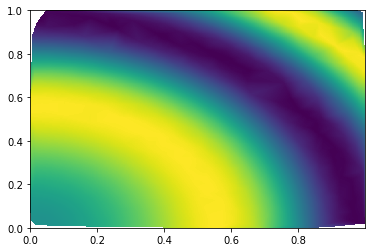

In [21]:
# Create triangulation
x = np.random.rand(1000)
y = np.random.rand(1000)
z = np.sin((x**2 + y**2)*5.0)

pts = np.vstack((x,y)).T
tri = spatial.Delaunay(pts)

# create an iterpolation object, f. We need to supply the data values on the specified xy points.
f = scipy.interpolate.LinearNDInterpolator(tri, z)

# Now interpolate to new values 
xi = np.linspace(x.min(), x.max(), 501)
yi = np.linspace(y.min(), y.max(), 501)
X, Y = np.meshgrid(xi, yi)  # uniform grid
Z = f(X, Y)  # this is the interpolation step

Z = np.ma.masked_where(np.isnan(Z), Z)

plt.pcolormesh(X, Y, Z, cmap='viridis')
# plt.scatter(x, y, 50, z, cmap='viridis')

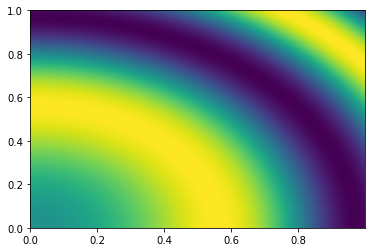

In [22]:
Z_true = np.sin((X**2 + Y**2)*5)
plt.pcolormesh(X, Y, Z_true, cmap='viridis')